<a href="https://colab.research.google.com/github/naryst/NER_russian_BERT/blob/master/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown 1FbAhm8H7MtPN_CJj-kYuI7jy_CRQsuys

Downloading...
From: https://drive.google.com/uc?id=1FbAhm8H7MtPN_CJj-kYuI7jy_CRQsuys
To: /content/data.zip
100% 3.83M/3.83M [00:00<00:00, 253MB/s]


In [2]:
!unzip data.zip

Archive:  data.zip
   creating: test_data/
  inflating: __MACOSX/._test_data    
  inflating: test_data/113534_text.txt  
  inflating: __MACOSX/test_data/._113534_text.txt  
  inflating: test_data/547532_text.txt  
  inflating: __MACOSX/test_data/._547532_text.txt  
  inflating: test_data/204220_text.txt  
  inflating: __MACOSX/test_data/._204220_text.txt  
  inflating: test_data/185911_text.txt  
  inflating: __MACOSX/test_data/._185911_text.txt  
  inflating: test_data/194112_text.txt  
  inflating: __MACOSX/test_data/._194112_text.txt  
  inflating: test_data/210104_text.txt  
  inflating: __MACOSX/test_data/._210104_text.txt  
  inflating: test_data/113627_text.txt  
  inflating: __MACOSX/test_data/._113627_text.txt  
  inflating: test_data/546519_text.txt  
  inflating: __MACOSX/test_data/._546519_text.txt  
  inflating: test_data/191113_text.txt  
  inflating: __MACOSX/test_data/._191113_text.txt  
  inflating: test_data/.DS_Store     
  inflating: __MACOSX/test_data/._.DS_Store 

In [3]:
!pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 86.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 23.9 MB/s eta 0:00:00


In [4]:
import os
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch
import torch.nn
from torch.utils.data import Dataset, DataLoader
import torch.optim
from tqdm import tqdm

In [5]:
ROOT_DIR = "train_data/"
texts50 = ROOT_DIR + "50texts_tacred/"
cll3 = ROOT_DIR + "coll3_tacred/"
legal = ROOT_DIR + "legal/"
tacred2 = ROOT_DIR + "tacred2/"
tacred3 = ROOT_DIR + "tacred3/"

In [6]:
def create_dataframe(dir):
    df = pd.DataFrame(columns=["fName", "text", "entities"])
    df = df.set_index("fName")
    files = os.listdir(dir)
    for name in files:
        fname, ext = name.split(".")
        with open(dir + name) as f:
            text = f.read()
        if ext == "txt":
            ann_fname = files[files.index(fname + ".ann")]
            with open(dir + ann_fname) as f_ann:
                entities = f_ann.readlines()
            new_entities = []
            for i in range(len(entities)):
                entity_type = entities[i][0]
                entities[i] = entities[i][:-1]
                if entity_type == "T":
                    entities[i] = entities[i].split("\t")
                    entities[i] = entities[i][1:]
                    src = entities[i][1]
                    entities[i] = entities[i][0].split()
                    entities[i].append(src)
                    assert len(entities[i]) <= 5
                    if len(entities[i]) == 5:
                        begin = entities[i][1]
                        inter1, inter2 = entities[i][2].split(";")
                        end = entities[i][3]
                        new_entities.append(
                            [entities[i][0], begin, inter1, entities[i][4]]
                        )
                        new_entities.append(
                            [entities[i][0], inter2, end, entities[i][4]]
                        )
                    else:
                        new_entities.append(entities[i])
            df.loc[fname] = [text, new_entities]
    return df

In [7]:
df1 = create_dataframe(texts50)
df2 = create_dataframe(cll3)
df3 = create_dataframe(legal)
df4 = create_dataframe(tacred2)
df5 = create_dataframe(tacred3)

In [8]:
df1.shape[0] + df2.shape[0] + df3.shape[0] + df4.shape[0] + df5.shape[0]

841

In [9]:
total_df = pd.concat([df1, df2, df3, df4, df5])

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
# change the parameter of max tokens what model can process to get tokenization of the whole input
# (not only first 512 tokens, which BERT can process  by its architecture)
# tokenizer = AutoTokenizer.from_pretrained(
#     "yqelz/xml-roberta-large-ner-russian", model_max_length=int(1.5e4)
# )

tokenizer = AutoTokenizer.from_pretrained("Evolett/rubert-tiny2-finetuned-ner")

In [12]:
def identify_tokens(df_sample):
    sample_text = df_sample["text"]
    sample_en = df_sample["entities"]
    sample_text_tokenized = tokenizer.tokenize(sample_text)
    trash_symbols_count = []
    for i in range(len(sample_text)):
        cur = (
            1
            if (
                sample_text[i] == " "
                or sample_text[i] == "\n"
                or sample_text[i] == "\xa0"
            )
            else 0
        )
        if i == 0:
            trash_symbols_count.append(cur)
        else:
            trash_symbols_count.append(trash_symbols_count[-1] + cur)
    cur_entity_id = 0
    processed_symbols = 0
    mappings = []
    begin = int(sample_en[cur_entity_id][1])
    end = int(sample_en[cur_entity_id][2])
    assert end < len(trash_symbols_count)
    begin -= trash_symbols_count[begin]
    end -= trash_symbols_count[end]

    for token in sample_text_tokenized:
        while processed_symbols > end and (cur_entity_id + 1) < len(sample_en):
            cur_entity_id += 1
            begin = int(sample_en[cur_entity_id][1])
            end = int(sample_en[cur_entity_id][2]) - 1
            begin -= trash_symbols_count[begin]
            end -= trash_symbols_count[end]
        if begin <= processed_symbols <= end:
            first_token = not (
                len(mappings) != 0 and sample_en[cur_entity_id] == mappings[-1][1]
            )
            mappings.append((token, sample_en[cur_entity_id], first_token))
        else:
            mappings.append((token, False))
        subword_check = token[:2] == '##'
        processed_symbols = processed_symbols + len(token) - int(subword_check) * 2

    for i in range(len(mappings)):
        if len(mappings[i]) == 2:
            mappings[i] = "O"
        else:
            if mappings[i][-1]:
                mappings[i] = "B-" + mappings[i][1][0]
            else:
                mappings[i] = "I-" + mappings[i][1][0]
    mappings.insert(0, "O")  # start token
    mappings.append("O")  # end token
    return mappings

In [13]:
total_df["tokenized_text"] = total_df["text"].apply(tokenizer.tokenize)
total_df["tokenizer_output"] = total_df["text"].apply(
    lambda x: tokenizer(x, return_tensors="pt", padding=True, truncation=True)
)
# add start and end tokens to map tokenizer output
total_df["tokenized_text"] = total_df["tokenized_text"].apply(
    lambda x: ["<s>"] + x + ["</s>"]
)
total_df["classified_tokens"] = total_df.apply(identify_tokens, axis=1)

Token indices sequence length is longer than the specified maximum sequence length for this model (2392 > 2048). Running this sequence through the model will result in indexing errors


In [14]:
total_df.reset_index(inplace=True)
total_df.head()

,fName,text,entities,tokenized_text,tokenizer_output,classified_tokens
0,121809_text,Лионель Месси женился\n\nЛионель Месси\nЗвезда...,"[[PERSON, 0, 13, Лионель Месси], [PERSON, 23, ...","[<s>, Лионе, ##ль, Месси, женился, Лионе, ##ль...","[input_ids, token_type_ids, attention_mask]","[O, B-PERSON, I-PERSON, I-PERSON, O, B-PERSON,..."
1,120043_text,Императору Японии разрешили сложить полномочия...,"[[PROFESSION, 0, 10, Императору], [COUNTRY, 11...","[<s>, Император, ##у, Японии, разрешили, сложи...","[input_ids, token_type_ids, attention_mask]","[O, B-PROFESSION, I-PROFESSION, B-COUNTRY, O, ..."
2,107415_text,У Бооса родился сын\n\nГеоргий Боос\nУ бывшего...,"[[PERSON, 2, 7, Бооса], [PERSON, 21, 33, Георг...","[<s>, У, Бо, ##оса, родился, сын, Георгий, Бо,...","[input_ids, token_type_ids, attention_mask]","[O, O, B-PERSON, I-PERSON, O, O, B-PERSON, I-P..."
3,112371_text,Брата Ким Чен Ына убили отравленными иглами\n\...,"[[PERSON, 6, 17, Ким Чен Ына], [CITY, 54, 66, ...","[<s>, Брат, ##а, Ким, Чен, Ын, ##а, убили, отр...","[input_ids, token_type_ids, attention_mask]","[O, O, O, B-PERSON, I-PERSON, I-PERSON, I-PERS..."
4,109428_text,Умер Фидель Кастро\n\nФидель Кастро\n26 ноября...,"[[PERSON, 5, 18, Фидель Кастро], [PERSON, 20, ...","[<s>, Умер, Фид, ##ель, Кастро, Фид, ##ель, Ка...","[input_ids, token_type_ids, attention_mask]","[O, O, B-PERSON, I-PERSON, I-PERSON, B-PERSON,..."


<Axes: >

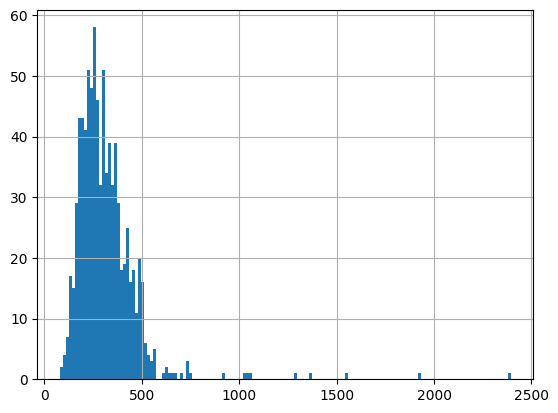

In [15]:
total_df["tokenized_text"].apply(len).hist(bins=150)

In [16]:
lens = total_df["classified_tokens"].apply(len)
print(
    f"Number of samples in train dataset, which have more tokens, when BERT can process - {lens[lens > 512].count() / lens.count() * 100:.3f}%"
)

Number of samples in train dataset, which have more tokens, when BERT can process - 4.281%


Dataset have 21% of samples, what can't be processed by BERT(For example, in document '1109' input text tokenized at more than 3000 tokens). To deal with this problem, we will use sliding window approach. We will split each sample into several samples, each of which will contain 512 tokens. We will use 256 tokens overlap between samples.

In [17]:
total_df["input_ids"] = total_df["tokenizer_output"].apply(lambda x: x["input_ids"])
total_df["attention_mask"] = total_df["tokenizer_output"].apply(
    lambda x: x["attention_mask"]
)

In [18]:
# sample = total_df[total_df["fName"] == "1109"]
sample = total_df.iloc[39]
iids = sample["input_ids"]
attn = sample["attention_mask"]
iids.shape, attn.shape, len(sample["tokenized_text"])

(torch.Size([1, 303]), torch.Size([1, 303]), 303)

In [19]:
# drop useless columns
total_df.drop(["entities", "text", "tokenizer_output"], axis=1, inplace=True)

In [20]:
# split samples with more than 512 tokens
def split_sample(sample):
    tokenized_text = sample["tokenized_text"]
    classified_entities = sample["classified_tokens"]
    fname = sample["fName"]
    input_ids = sample["input_ids"]
    attention_mask = sample["attention_mask"]

    max_len = 512
    overlap = max_len // 2

    if input_ids.shape[1] <= max_len:
        return pd.DataFrame(
            [[fname, input_ids, attention_mask, tokenized_text, classified_entities]],
            columns=[
                "fName",
                "input_ids",
                "attention_mask",
                "tokenized_text",
                "classified_tokens",
            ],
        )
    else:
        samples = []
        for i in range(0, len(tokenized_text), overlap):
            if i + max_len <= len(tokenized_text):
                samples.append(
                    [
                        fname,
                        input_ids[:, i : i + max_len],
                        attention_mask[:, i : i + max_len],
                        tokenized_text[i : i + max_len],
                        classified_entities[i : i + max_len],
                    ]
                )
            else:
                samples.append(
                    [
                        fname,
                        input_ids[:, -max_len:],
                        attention_mask[:, -max_len:],
                        tokenized_text[-max_len:],
                        classified_entities[-max_len:],
                    ]
                )
        return pd.DataFrame(
            samples,
            columns=[
                "fName",
                "input_ids",
                "attention_mask",
                "tokenized_text",
                "classified_tokens",
            ],
        )

In [21]:
total_df

,fName,tokenized_text,classified_tokens,input_ids,attention_mask
0,121809_text,"[<s>, Лионе, ##ль, Месси, женился, Лионе, ##ль...","[O, B-PERSON, I-PERSON, I-PERSON, O, B-PERSON,...","[[tensor(2), tensor(66768), tensor(1903), tens...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
1,120043_text,"[<s>, Император, ##у, Японии, разрешили, сложи...","[O, B-PROFESSION, I-PROFESSION, B-COUNTRY, O, ...","[[tensor(2), tensor(37336), tensor(644), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
2,107415_text,"[<s>, У, Бо, ##оса, родился, сын, Георгий, Бо,...","[O, O, B-PERSON, I-PERSON, O, O, B-PERSON, I-P...","[[tensor(2), tensor(299), tensor(26576), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
3,112371_text,"[<s>, Брат, ##а, Ким, Чен, Ын, ##а, убили, отр...","[O, O, O, B-PERSON, I-PERSON, I-PERSON, I-PERS...","[[tensor(2), tensor(27158), tensor(603), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
4,109428_text,"[<s>, Умер, Фид, ##ель, Кастро, Фид, ##ель, Ка...","[O, O, B-PERSON, I-PERSON, I-PERSON, B-PERSON,...","[[tensor(2), tensor(18392), tensor(63698), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
...,...,...,...,...,...
836,1530089_text,"[<s>, Кис, ##ин, :, Продолж, ##айте, делать, в...","[O, B-PERSON, I-PERSON, I-PERSON, O, O, O, O, ...","[[tensor(2), tensor(40934), tensor(1849), tens...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
837,105025_text,"[<s>, Мусуль, ##ман, ##ская, организация, пред...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-PROF...","[[tensor(2), tensor(81113), tensor(3125), tens...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
838,11597_text,"[<s>, Аргентина, потеряла, бывшего, президента...","[O, B-COUNTRY, O, O, B-PROFESSION, B-DATE, I-D...","[[tensor(2), tensor(25404), tensor(38058), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
839,133121_text,"[<s>, Харви, Вайн, ##штейна, навсегда, исключи...","[O, B-PERSON, I-PERSON, I-PERSON, O, O, O, B-O...","[[tensor(2), tensor(66527), tensor(53707), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."


In [22]:
# total_df = total_df.apply(split_sample, axis=1)

In [23]:
# total_df = pd.concat(total_df.values)
total_df.reset_index(inplace=True)
total_df.drop("index", axis=1, inplace=True)

<Axes: >

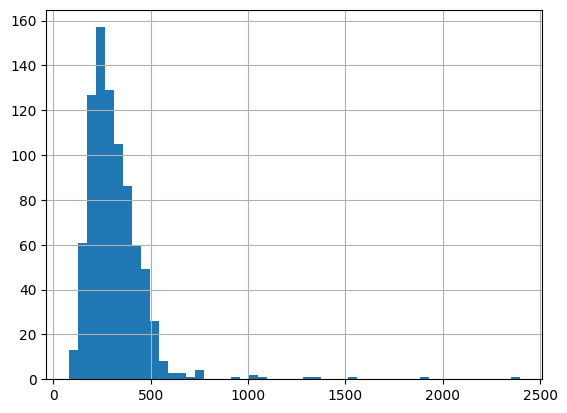

In [24]:
total_df["tokenized_text"].apply(len).hist(bins=50)

In [25]:
# test token mapping for the sample
n = 25
sample = total_df.iloc[n]
sample_tokens = sample["tokenized_text"]
sample_entities = sample["classified_tokens"]
a = np.array([sample_tokens, sample_entities])
a.T

array([['<s>', 'O'],
       ['Умер', 'O'],
       ['Эдуард', 'B-PERSON'],
       ['Назаров', 'I-PERSON'],
       ['[UNK]', 'O'],
       ['создатель', 'O'],
       ['мультфильма', 'O'],
       ['«', 'B-WORK_OF_ART'],
       ['Жил', 'I-WORK_OF_ART'],
       ['-', 'I-WORK_OF_ART'],
       ['был', 'I-WORK_OF_ART'],
       ['пёс', 'B-PERSON'],
       ['»', 'I-PERSON'],
       ['Эдуард', 'I-PERSON'],
       ['Назаров', 'I-PERSON'],
       ['11', 'B-DATE'],
       ['сентября', 'I-DATE'],
       ['2016', 'I-DATE'],
       ['года', 'B-AGE'],
       ['на', 'I-AGE'],
       ['75', 'I-AGE'],
       ['году', 'O'],
       ['жизни', 'O'],
       ['в', 'B-CITY'],
       ['Москве', 'I-CITY'],
       ['скончался', 'O'],
       ['советский', 'B-NATIONALITY'],
       ['и', 'B-NATIONALITY'],
       ['российский', 'I-NATIONALITY'],
       ['мультиплика', 'O'],
       ['##тор', 'O'],
       [',', 'O'],
       ['режиссёр', 'O'],
       ['и', 'O'],
       ['художник', 'O'],
       [',', 'B-AWARD'],
       ['на

In [26]:
unique_entities = []
for sample in total_df["classified_tokens"]:
    for token in sample:
        unique_entities.append(token)
unique_entities = np.unique(unique_entities)

In [27]:
id2label = {}
label2id = {}

for i in range(len(unique_entities)):
    id2label[i] = unique_entities[i]
    label2id[unique_entities[i]] = i

In [28]:
labels_num = len(unique_entities)

In [29]:
labels_num

59

In [30]:
class BertTokenClassification(torch.nn.Module):
    def __init__(self):
        super(BertTokenClassification, self).__init__()
        # transformers.models.xlm_roberta.modeling_xlm_roberta.XLMRobertaForTokenClassification
        # self.bert = AutoModelForTokenClassification.from_pretrained(
        #     "yqelz/xml-roberta-large-ner-russian"
        # )
        self.bert = AutoModelForTokenClassification.from_pretrained("Evolett/rubert-tiny2-finetuned-ner")

        self.bert.id2label = id2label
        self.bert.label2id = label2id
        self.bert.num_labels = labels_num
        self.bert.classifier = torch.nn.Linear(312, labels_num)

    def forward(self, input_id, mask, label=None):
        output = self.bert(input_ids=input_id, attention_mask=mask, labels=label)
        return output

In [31]:
class TextDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe

    def __len__(self):
        return len(self.df)

    @staticmethod
    def df_sample_to_tensor(row):
        data = row["input_ids"]
        labels = row["classified_tokens"]
        labels = list(map(lambda x: label2id[x], labels))
        labels = torch.tensor(labels)
        data = torch.squeeze(data).int()
        # print(labels.shape, data.shape)
        return data, labels

    def __getitem__(self, idx):
        return self.df_sample_to_tensor(self.df.iloc[idx])

In [32]:
# complement input ids and attention mask
# to 512 elements, to bring all tensors to the same shape
def tokenization_complement(tensor):
    complement_size = 2048 - tensor.shape[1]
    if complement_size < 0:
        return tensor[:, :2048]
    zeros_complement = torch.zeros((1, complement_size))
    new_sample = torch.cat(
        (
            tensor,
            zeros_complement,
        ),
        dim=1,
    )
    assert new_sample.shape[1] == 2048
    return new_sample


# complement labels to the form of tensors
def labels_complement(labels):
    complement_size = 2048 - len(labels)
    if complement_size < 0:
        return labels[:2048]
    new_labels = labels
    for i in range(complement_size):
        new_labels.append("O")
    return new_labels

In [33]:
total_df["input_ids"] = total_df["input_ids"].apply(tokenization_complement)
total_df["attention_mask"] = total_df["attention_mask"].apply(tokenization_complement)

In [34]:
total_df["classified_tokens"] = total_df["classified_tokens"].apply(labels_complement)

In [35]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(total_df, train_size=0.9)

In [36]:
BATCH_SIZE = 2
lr = 3e-4
EPOCH_NUMBER = 20


def train_loop(model, train_d, val_d, epoch_num=EPOCH_NUMBER):
    train_dataset = TextDataset(train_d)
    val_dataset = TextDataset(val_d)

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    for epoch in range(epoch_num):
        acc_train = 0
        cur_loss_train = 0
        acc_val = 0
        loss_val = 0

        model.train()
        for data, labels in tqdm(train_dataloader):
            attention_mask = (data != 0).float().to(device)
            data = data.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            # print(data.shape)
            # print(labels.shape)
            output = model(data, attention_mask, labels)
            loss, logits = output[0], output[1]
            # print(logits.shape)
            # break
            for i in range(logits.shape[0]):
                clean_logits = logits[i][labels[i] != 58]
                clean_labels = labels[i][labels[i] != 58]
                
                predictions = clean_logits.argmax(dim=1)
                acc = (predictions == clean_labels).float().mean()
                acc_train += acc
                cur_loss_train += loss.item()

            loss.backward()
            optimizer.step()

        model.eval()
        for data, labels in tqdm(val_dataloader):
            attention_mask = (data != 0).float().to(device)
            data = data.to(device)
            labels = labels.to(device)
            output = model(data, attention_mask, labels)
            loss, logits = output[0], output[1]
            for i in range(logits.shape[0]):
                clean_logits = logits[i][labels[i] != 58]
                clean_labels = labels[i][labels[i] != 58]

                predictions = clean_logits.argmax(dim=1)
                acc = (predictions == clean_labels).float().mean()
                acc_val += acc
                loss_val += loss.item()

        print(
            f"Epochs: {epoch + 1} | train Loss: {cur_loss_train / len(train_d): .3f} | train Accuracy: {acc_train / len(train_d): .3f}"
        )
        print(
            f"val Loss: {loss_val / len(val_d): .3f} | train Accuracy: {acc_val / len(val_d): .3f}"
        )

In [37]:
torch.cuda.empty_cache()

In [38]:
model = BertTokenClassification().to(device)

In [39]:
train_loop(model, train_data, val_data)

100%|██████████| 43/43 [00:02<00:00, 17.44it/s]


Epochs: 1 | train Loss:  0.200 | train Accuracy:  0.221
val Loss:  0.111 | train Accuracy:  0.468


100%|██████████| 43/43 [00:02<00:00, 17.53it/s]


Epochs: 2 | train Loss:  0.111 | train Accuracy:  0.478
val Loss:  0.098 | train Accuracy:  0.563


100%|██████████| 43/43 [00:02<00:00, 17.44it/s]


Epochs: 3 | train Loss:  0.081 | train Accuracy:  0.606
val Loss:  0.099 | train Accuracy:  0.560


100%|██████████| 43/43 [00:02<00:00, 17.20it/s]


Epochs: 4 | train Loss:  0.059 | train Accuracy:  0.709
val Loss:  0.102 | train Accuracy:  0.597


100%|██████████| 43/43 [00:02<00:00, 17.25it/s]


Epochs: 5 | train Loss:  0.045 | train Accuracy:  0.782
val Loss:  0.107 | train Accuracy:  0.576


100%|██████████| 43/43 [00:02<00:00, 17.05it/s]


Epochs: 6 | train Loss:  0.035 | train Accuracy:  0.831
val Loss:  0.117 | train Accuracy:  0.614


100%|██████████| 43/43 [00:02<00:00, 17.01it/s]


Epochs: 7 | train Loss:  0.028 | train Accuracy:  0.865
val Loss:  0.124 | train Accuracy:  0.625


100%|██████████| 43/43 [00:02<00:00, 17.11it/s]


Epochs: 8 | train Loss:  0.023 | train Accuracy:  0.890
val Loss:  0.129 | train Accuracy:  0.618


100%|██████████| 43/43 [00:02<00:00, 17.23it/s]


Epochs: 9 | train Loss:  0.020 | train Accuracy:  0.905
val Loss:  0.135 | train Accuracy:  0.577


100%|██████████| 43/43 [00:02<00:00, 17.32it/s]


Epochs: 10 | train Loss:  0.017 | train Accuracy:  0.920
val Loss:  0.137 | train Accuracy:  0.587


100%|██████████| 43/43 [00:02<00:00, 17.35it/s]


Epochs: 11 | train Loss:  0.014 | train Accuracy:  0.930
val Loss:  0.152 | train Accuracy:  0.579


100%|██████████| 43/43 [00:02<00:00, 17.37it/s]


Epochs: 12 | train Loss:  0.013 | train Accuracy:  0.938
val Loss:  0.154 | train Accuracy:  0.602


100%|██████████| 43/43 [00:02<00:00, 17.41it/s]


Epochs: 13 | train Loss:  0.011 | train Accuracy:  0.946
val Loss:  0.159 | train Accuracy:  0.567


 27%|██▋       | 103/378 [00:17<00:47,  5.77it/s]


KeyboardInterrupt: ignored

In [40]:
torch.save(model.state_dict(), "model.pth")

In [41]:
test_dir = "test_data/"

In [42]:
texts = []
f_names = []
for file_name in os.listdir(test_dir):
    file_path = test_dir + file_name
    # print(file_name)
    if file_name.split(".")[1] == "txt":
        with open(file_path) as f:
            cur_text = f.read()
        texts.append(cur_text)
        f_names.append(file_name)

test_df = pd.DataFrame({"fName": f_names, "text": texts})

In [43]:
test_df["tokenized_text"] = test_df["text"].apply(tokenizer.tokenize)

In [44]:
test_df["tokenized_text"] = test_df["tokenized_text"].apply(
    lambda x: ["START"] + x + ["END"]
)

<Axes: >

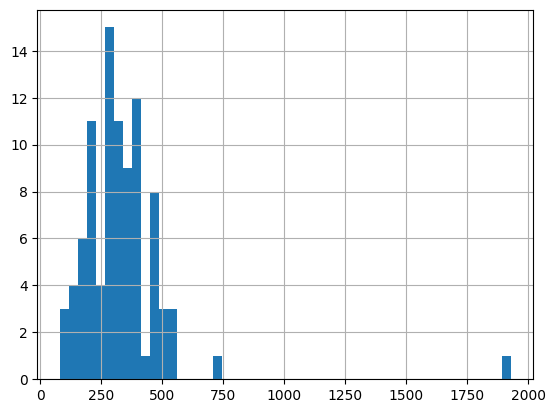

In [45]:
test_df["tokenized_text"].apply(len).hist(bins=50)

In [46]:
test_df["tokenizer_output"] = test_df["text"].apply(
    lambda x: tokenizer(x, return_tensors="pt", padding=True, truncation=True)
)

In [47]:
test_df

,fName,text,tokenized_text,tokenizer_output
0,197654_text.txt,Военная операция в Афганистане унесла жизни 10...,"[START, Военная, операция, в, Афганистане, уне...","[input_ids, token_type_ids, attention_mask]"
1,114891_text.txt,Сенатор Вадим Тюльпанов погиб в бане\n\nВадим ...,"[START, Сенатор, Вадим, Тю, ##ль, ##панов, пог...","[input_ids, token_type_ids, attention_mask]"
2,548634_text.txt,Умер Эдуард Лимонов\nЭдуард Лимонов\nВо вторни...,"[START, Умер, Эдуард, Ли, ##монов, Эдуард, Ли,...","[input_ids, token_type_ids, attention_mask]"
3,113627_text.txt,Depeche Mode выпустил новый альбом Spirit\n\nВ...,"[START, De, ##peche, Mode, выпустил, новый, ал...","[input_ids, token_type_ids, attention_mask]"
4,209731_text.txt,Куинджи нашли в Заречье\nАрхип Куинджи «Ай-Пет...,"[START, Куи, ##нд, ##жи, нашли, в, Заре, ##чье...","[input_ids, token_type_ids, attention_mask]"
...,...,...,...,...
87,197682_text.txt,Впервые за 10 лет Золотой мяч не получили ни Р...,"[START, Впервые, за, 10, лет, Золотой, мяч, не...","[input_ids, token_type_ids, attention_mask]"
88,207937_text.txt,Мэр Гданьска погиб после ножевой атаки на благ...,"[START, Мэр, Г, ##дан, ##ь, ##ска, погиб, посл...","[input_ids, token_type_ids, attention_mask]"
89,198350_text.txt,Китайскую компанию наказали за японскую порноа...,"[START, Китай, ##скую, компанию, наказ, ##али,...","[input_ids, token_type_ids, attention_mask]"
90,539976_text.txt,Тайский стрелок убил 26 человек из-за проблем ...,"[START, Тай, ##ский, стрелок, убил, 26, челове...","[input_ids, token_type_ids, attention_mask]"


In [48]:
def model_inference(text):
    model_input = tokenizer(text)
    input_len = len(model_input["input_ids"])
    input_ids = torch.tensor(model_input["input_ids"]).unsqueeze(0).to(device)
    print(input_len)
    attention_mask = torch.tensor(model_input["attention_mask"]).unsqueeze(0).to(device)
    output = model(input_ids, attention_mask)
    logits = output[0]
    predictions = logits.argmax(dim=2).squeeze(0)
    # print(logits)
    print(input_ids)
    print(logits.shape)
    result = []
    for prediction in predictions:
        result.append(id2label[prediction.item()])
    print(result)

In [49]:
sample_text = df1.iloc[5].text
print(sample_text)
model_inference(sample_text)

Елизавета II — самый долгоправящий живой монарх в мире

Елизавета II
Королева Великобритании Елизавета II находится на троне дольше всех ныне живущих монархов мира. В звании самого долгоправящего монарха 90-летняя правительница сменила скончавшегося 13 октября 89-летнего короля Таиланда Пхумипона Адульядета. Он взошел на престол в 1946 году.

В сентябре 2015 года сообщалось, что Елизавета II официально стала самым долгоправящим монархом в истории Великобритании.

Она превзошла рекорд своей прапрабабушки королевы Виктории по продолжительности пребывания на троне, который составлял 23 тысячи 226 дней, 16 часов и 23 минуты.

Елизавета Александра Мария родилась 21 апреля 1926 года в Лондоне в семье герцога и герцогини Йоркских.

Королевой Великобритании она была провозглашена 6 февраля 1952 года.
В этот день умер её отец, король Георг VI.
Официальная церемония коронации состоялась 2 июня 1953 года в Вестминстерском аббатстве в Лондоне.




184
tensor([[    2, 45196,   736,     1, 19389, 27